In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm

In [2]:
""" 
Obtaining data from a given expt
"""
csv_train = pd.read_csv('dummy_task/train_three_tones_v5_file.csv')
csv_test = pd.read_csv('dummy_task/test_three_tones_v5_file.csv')
csv_data = pd.read_csv('auditory_categorization_online_data/auditory_categorization_task_81488_2020-12-07_22h54.27_2886f998-38df-11eb-90ef-d05099d383f7/NV_categorization_task_2020-11-28_10h13.20.734.csv');

In [3]:
n_tones = 3
n_trials = 507

"""
Get tones and values of keys pressed
"""
train_columns = list(csv_train.columns)
train_tones_name = train_columns.index('Name')
train_tones_col_idx = train_columns.index('Tones')
df1_names = (csv_train.iloc[0:100,train_tones_name]).values
df1_tones = (csv_train.iloc[0:100,train_tones_col_idx]).values

test_columns = list(csv_test.columns)
test_tones_name = test_columns.index('Name')
test_tones_col_idx = test_columns.index('Tones')
df2_names = (csv_test.iloc[0:400,test_tones_name]).values
df2_tones = (csv_test.iloc[0:400,test_tones_col_idx]).values

tones_array = np.zeros((n_trials,n_tones))
for i_wav in range(7,107):
    tones_array[i_wav,:] = np.array(df1_tones[np.where(csv_data['Name'][i_wav]\
                                                       
                                                        ==df1_names)[0]][0][1:-1].split(',')).astype(float)     
for i_wav in range(107,507):
    tones_array[i_wav,:] = np.array(df2_tones[np.where(csv_data['Name'][i_wav]\
                                                        ==df2_names)[0]][0][1:-1].split(',')).astype(float)  
    
df_tones = np.copy(tones_array)
df_corrans = np.copy(csv_data['corrAns'])
df_keys = np.concatenate((csv_data['resp.keys'][7:107],csv_data['test_resp.keys'][107:507]))

In [4]:
"""
Find no response cases in the expt
"""
no_response = np.intersect1d(np.where(df_keys!='h')[0],np.where(df_keys!='l')[0])
print("Did not respond to: ",no_response)

"""
Convert keys ['l','h'] to [0,1] and plot p(H|T)
"""
corrans_num = np.zeros_like(df_corrans)
corrans_num[df_corrans == 'h'] = 1

keys_num = np.zeros_like(df_keys)
keys_num[df_keys == 'h'] = 1

tones_array = tones_array[7:507,:]
corrans_num = corrans_num[7:507]
print("Got correct: ", np.sum(keys_num==corrans_num))

Did not respond to:  [  0   1   2   4  69  83 108 109 112 184 235 251 275 322 391 444 464]
Got correct:  399


In [5]:
trial_tones = np.repeat(tones_array,1,axis = 0)
trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
# this has been changed to check how values change with observer responses

expt_tones = np.arange(100,2000,1) #array of possible true tones
log_freq_seq_array = np.arange(np.log10(expt_tones[0]), np.log10(expt_tones[-1]), \
                               np.log10(1003/1000)*30)
log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, \
                             np.log10(expt_tones[-1])+0.5, 0.05) # array of possible perceptual tones

idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
trial_tones = trial_tones[idxs_with_response,:]
trial_behaviour = trial_behaviour[idxs_with_response]

log_freq_seq_array

array([2.        , 2.03902799, 2.07805598, 2.11708397, 2.15611196,
       2.19513995, 2.23416794, 2.27319593, 2.31222392, 2.35125192,
       2.39027991, 2.4293079 , 2.46833589, 2.50736388, 2.54639187,
       2.58541986, 2.62444785, 2.66347584, 2.70250383, 2.74153182,
       2.78055981, 2.8195878 , 2.85861579, 2.89764378, 2.93667177,
       2.97569977, 3.01472776, 3.05375575, 3.09278374, 3.13181173,
       3.17083972, 3.20986771, 3.2488957 , 3.28792369])

In [6]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def posterior_array(log_freq_percept, n_tones, p_back, p_low, 
                    log_prior_low, log_prior_high):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background, p_low - prob of low condition
    log_prior_low - gaussian of low condition
    log_prior_high - gaussian of high condition
    """
    
    log_prior_low_mean = log_prior_low[0]; log_prior_low_sigma = log_prior_low[1];
    log_prior_high_mean = log_prior_high[0]; log_prior_high_sigma = log_prior_high[1];
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
    
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, prior_tones_high, prior_tones_low, normalizer, posterior

In [7]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_low_sigma, log_prior_high_mean, log_prior_high_sigma, p_back = \
    params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high #mixture model
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low #mixture model
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)

    if len(trial_tones[0]) == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif len(trial_tones[0]) == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
    
    p_low = 0.5 
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer  
       
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        if len(trial_tones[i_trial]) == 3: 
            input_array_0 = np.expand_dims(gaussian(log_freq_percept, \
                                                    mean = np.log10(trial_tones[i_trial][0]), \
                                                    sigma = 0.03), axis = 1)
            input_array_1 = np.expand_dims(gaussian(log_freq_percept, \
                                                    mean = np.log10(trial_tones[i_trial][1]), \
                                                    sigma = 0.03), axis = 1)
            input_array_2 = np.expand_dims(gaussian(log_freq_percept, \
                                                    mean = np.log10(trial_tones[i_trial][2]), \
                                                    sigma = 0.03), axis = 1)
            input_array_mat = np.expand_dims(input_array_0@np.transpose\
                                             (input_array_1),axis=2)@np.transpose(input_array_2) #p(T1,T2..|H)     
            input_array_mat /= np.sum(input_array_mat)
            probability_high0 = np.sum(np.multiply(posterior,input_array_mat))
            probability_high[i_trial] = np.sum(np.multiply(posterior,input_array_mat))
            # pdb.set_trace()
            
        elif len(trial_tones[i_trial]) == 1:
            for i_post in range(len(posterior)):
                input_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][0]), sigma = 0.03)
                input_array /= np.sum(input_array)
                input_array = np.expand_dims(input_array, axis = 1)            
                probability_high0 = np.transpose(posterior)@input_array
                probability_high[i_trial] = np.transpose(posterior)@input_array
            # pdb.set_trace()
            
        if trial_behaviour[i_trial]:
            if np.isnan(np.log(probability_high0 + 0.0000001)) \
            or np.isinf(np.log(probability_high0 + 0.0000001)) \
            or np.isnan(np.log(1-probability_high0 + 0.0000001)) \
            or np.isinf(np.log(1-probability_high0 + 0.0000001)):
                pdb.set_trace()
            neg_ll += -np.log(probability_high0 + 0.0000001) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + 0.0000001) # if low dist is chosen by observer
    return(neg_ll)

In [8]:
guess_low_mean = np.arange(2.1,2.6,0.05); guess_low_sigma = np.arange(0.05,0.2,0.05)
guess_high_mean = np.arange(2.7,3.2,0.05); guess_high_sigma = np.arange(0.05,0.2,0.05)
guess_p_back = np.arange(0.1,1,0.1)

# Constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. 

neg_ll_array = np.zeros((len(guess_low_mean),len(guess_low_sigma),\
                         len(guess_high_mean),len(guess_high_sigma),len(guess_p_back)))
for lm in tqdm(range(len(guess_low_mean))):
    for ls in tqdm(range(len(guess_low_sigma)), leave=False, desc="Low sigma"):
        for hm in range(len(guess_high_mean)):
            for hs in range(len(guess_high_sigma)):
                for pb in range(len(guess_p_back)):
                    params = [guess_low_mean[lm], guess_low_sigma[ls], guess_high_mean[hm], \
                              guess_high_sigma[hs], guess_p_back[pb]]
                    # print(lm, hm, pb)
                    neg_ll_array[lm,ls,hm,hs,pb] = MLE(params)      

In [9]:
"""
Means and p_back corresponding to the least negative log likelihood value
"""
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]],  guess_high_mean[idxs[2]], \
guess_high_sigma[idxs[3]], guess_p_back[idxs[4]], np.amin(neg_ll_array)

(array([2.15]),
 array([0.2]),
 array([3.1]),
 array([0.15]),
 array([0.9]),
 178.2591182013652)

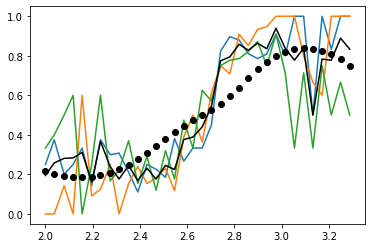

In [10]:
# Influence plots the way we currently understand them (11-17-2020)

unique_tones = np.unique(trial_tones)
tone1_prob_behaviour = np.zeros((len(unique_tones)))
tone2_prob_behaviour = np.zeros((len(unique_tones)))
tone3_prob_behaviour = np.zeros((len(unique_tones)))

for i_tone in range(len(unique_tones)):
    tone1_prob_behaviour[i_tone] = np.mean(trial_behaviour[trial_tones[:,0]\
                                                       ==unique_tones[i_tone]])
    tone2_prob_behaviour[i_tone] = np.mean(trial_behaviour[trial_tones[:,1]\
                                                       ==unique_tones[i_tone]])
    tone3_prob_behaviour[i_tone] = np.mean(trial_behaviour[trial_tones[:,2]\
                                                       ==unique_tones[i_tone]])
plt.plot(np.log10(unique_tones), tone1_prob_behaviour)
plt.plot(np.log10(unique_tones), tone2_prob_behaviour)
plt.plot(np.log10(unique_tones), tone3_prob_behaviour)
plt.plot(np.log10(unique_tones), (tone1_prob_behaviour+tone2_prob_behaviour+tone3_prob_behaviour)/3,'k')

_, _, _, _, _, posterior = \
posterior_array(log_freq_seq_array, n_tones=1, p_back=guess_p_back[idxs[4]], \
                p_low=0.5, log_prior_low=[guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]]], \
                log_prior_high=[guess_high_mean[idxs[2]],guess_high_sigma[idxs[3]]])
plt.plot(np.log10(unique_tones), posterior,'ko')

plt.savefig('figures/experimenter=NV_categorization_task_2020-11-28_10h13.20.734,match.png')